In [1]:
import os

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
import torch

import plotnine as p9
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(1, '../../LEMBAS')
from LEMBAS.model.bionetwork import format_network, SignalingModel
from LEMBAS.model.train import train_signaling_model
import LEMBAS.utilities as utils
from LEMBAS import plotting, io

In [3]:
n_cores = 12
utils.set_cores(n_cores)

seed = 888
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    utils.set_seeds(seed = seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = '../macrophage_data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

## Build the Model

### Load Input Data

In [4]:
# prior knowledge signaling network
net = pd.read_csv('https://zenodo.org/records/10815391/files/macrophage_network.tsv', sep = '\t', index_col = False)

# ligand input and TF output
ligand_input = pd.read_csv('https://zenodo.org/records/10815391/files/macrophage_ligands.tsv', sep = '\t', index_col = 0)
tf_output = pd.read_csv('https://zenodo.org/records/10815391/files/macrophage_TFs.tsv', sep='\t', low_memory=False, index_col=0)

Let's see what the signaling network looks like:

In [5]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'

net[[source_label, target_label, stimulation_label, inhibition_label]].head()

,source,target,stimulation,inhibition
0,P49137,Q16539,0,0
1,Q16539,P49137,1,0
2,P31749,O15111,1,0
3,O15111,P19838,1,0
4,P19838,O15111,0,0


Let's format it to fit with the necessary inputs to the SignalingModel:

In [6]:
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)
net[[source_label, target_label, weight_label, stimulation_label, inhibition_label]].head()

,source,target,mode_of_action,stimulation,inhibition
0,P49137,Q16539,0.1,0,0
1,Q16539,P49137,1.0,1,0
2,P31749,O15111,1.0,1,0
3,O15111,P19838,1.0,1,0
4,P19838,O15111,0.1,0,0


### Define Parameters to Build and Train Model

In [7]:
# linear scaling of inputs/outputs
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 5000, 
             'learning_rate': 2e-3}
other_params = {'batch_size': 8, 'noise_level': 10, 'gradient_noise_level': 1e-9}
regularization_params = {'param_lambda_L2': 1e-6, 'output_bias_lambda_L2': 1e-6,
                         'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 'uniform_lambda_L2': 1e-4, 
                   'uniform_min': 0, 'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 50, 'subset_n_spectral': 10}
target_spectral_radius = 0.8
hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params} # fed into training function

### Initialize Model
Next, let's initialize the model and format the inputs/outputs for running the model:

In [8]:
mod = SignalingModel(net = net,
                     X_in = ligand_input,
                     y_out = tf_output, 
                     projection_amplitude_in = projection_amplitude_in, projection_amplitude_out = projection_amplitude_out,
                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                     bionet_params = bionet_params, 
                     dtype = torch.float32, device = device, seed = seed)

The ligand input, after filtering for nodes in the network, looks like this:

In [9]:
mod.X_in.head()

,Ligand_GC,Ligand_IC,Ligand_IFNb,Ligand_IFNg,Ligand_IL10,Ligand_IL13,Ligand_IL4,Ligand_LPSc,Ligand_P3C,Ligand_PGE2,Ligand_TNFa,Ligand_upLPS
CON,0,0,0,0,0,0,0,0,0,0,0,0
GC,1,0,0,0,0,0,0,0,0,0,0,0
IFNb,0,0,1,0,0,0,0,0,0,0,0,0
IFNb+TNFa+PGE2+P3C,0,0,1,0,0,0,0,0,1,1,1,0
IFNb+TNFa+PGE2+P3C+IFNg,0,0,1,1,0,0,0,0,1,1,1,0


The TF activity output, after filtering for nodes in the network, looks like this:

In [10]:
mod.y_out.head()

,O43524,O75030,P01100,P01106,P03372,P04637,P05412,P08047,P10070,P10242,...,Q07869,Q08050,Q12778,Q13127,Q13485,Q14186,Q16665,Q9H3D4,Q9NQB0,Q9UJU2
CON,0.543487,0.506355,0.288705,0.524944,0.508840,0.535930,0.456016,0.799885,0.465701,0.407298,...,0.479674,0.404891,0.409449,0.568049,0.439274,0.702048,0.450063,0.147630,0.384904,0.677774
GC,0.677927,0.617778,0.119494,0.724938,0.613868,0.796771,0.011826,0.439144,0.421594,0.677585,...,0.299406,0.103314,0.656781,0.440104,0.544396,0.482236,0.094289,0.250332,0.209280,0.637135
IFNb,0.384689,0.621748,0.109474,0.352545,0.558823,0.512618,0.187316,0.326541,0.430194,0.573846,...,0.505945,0.732870,0.513355,0.429696,0.509111,0.545478,0.131642,0.557754,0.465558,0.649616
IFNb+TNFa+PGE2+P3C,0.894344,0.618304,0.815526,0.029120,0.789124,0.627074,0.393195,0.551965,0.399580,0.498236,...,0.241678,0.735164,0.709700,0.383326,0.503909,0.150867,0.736157,0.556562,0.390066,0.232772
IFNb+TNFa+PGE2+P3C+IFNg,0.757642,0.506760,0.772328,0.033346,0.645125,0.762146,0.619820,0.420949,0.406377,0.303368,...,0.088150,0.655950,0.762460,0.409982,0.199154,0.199775,0.818583,0.677592,0.346423,0.165553


A forward pass looks like this:

In [11]:
# X_in = mod.df_to_tensor(mod.X_in) # ligand inputs
# X_full = mod.input_layer(X_in) # ligand inputs in signaling network
# Y_full = mod.signaling_network(X_full) # signaling network weights
# Y_hat = mod.output_layer(Y_full) # TF outputs of signaling network

# Start dev

In [41]:
np.random.seed(888)
y_vals = pd.DataFrame(np.random.uniform(-1, 1, size=tf_output.shape), 
                      columns = tf_output.columns, 
                      index = tf_output.index)

In [42]:
# linear scaling of inputs/outputs
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 5000, 
             'learning_rate': 2e-3}
other_params = {'batch_size': 8, 'noise_level': 10, 'gradient_noise_level': 1e-9}
regularization_params = {'param_lambda_L2': 1e-6, 'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 
                         'uniform_lambda_L2': 1e-4, 
                   'uniform_min': 0, 'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 50, 'subset_n_spectral': 10}
target_spectral_radius = 0.8
hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params} # fed into training function

In [43]:
# hyper_params['param_lambda_L2'] = 0#1e-6
# hyper_params['output_bias_lambda_L2'] = 0#1e-6
# hyper_params['moa_lambda_L1'] = 0
# hyper_params['ligand_lambda_L2'] = 0
# hyper_params['spectral_loss_factor'] = 0

projection_amplitude_out = 0.3

# hyper_params['uniform_lambda_L2'] = 0#1e-4
# hyper_params['uniform_min'] = 0
# hyper_params['uniform_max'] = 1


In [44]:
hyper_params['max_iter'] = 100
# hyper_params['uniform_min'] = -1
# hyper_params['uniform_lambda_L2'] = 1e-1

In [45]:
mod = SignalingModel(net = net,
                     X_in = ligand_input,
                     y_out = y_vals, 
                     projection_amplitude_in = projection_amplitude_in, projection_amplitude_out = projection_amplitude_out,
                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                     bionet_params = bionet_params, 
                     dtype = torch.float32, device = device, seed = seed)

In [46]:
# with torch.inference_mode():
#     X_in = mod.df_to_tensor(mod.X_in)
#     X_full = mod.input_layer(X_in) # input ligands to signaling network
#     Y_full = mod.signaling_network(X_full) # RNN of full signaling network
# #     Y_hat = mod.output_layer(Y_full)

In [47]:
# model setup
mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

# loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam

# training loop
res = train_signaling_model(mod, optimizer, loss_fn,
                            reset_epoch = 200,
                            hyper_params = hyper_params,
                            train_split_frac = {'train': 0.8, 'test': 0.2, 'validation': None},
                            train_seed = seed,
                            verbose = True)
mod, cur_loss, cur_eig, mean_loss, stats, X_train, X_test, X_val, y_train, y_test, y_val = res

i=0, l=0.33048, s=0.769, r=0.00020, v=0
Training ran in: 0 min 26.00 sec


In [48]:
with torch.inference_mode():
#     X_in = mod.df_to_tensor(mod.X_in)
#     X_full = mod.input_layer(X_in) # input ligands to signaling network
    X_full = mod.input_layer(X_train)
    Y_full = mod.signaling_network(X_full) # RNN of full signaling network
    Y_hat = mod.output_layer(Y_full)

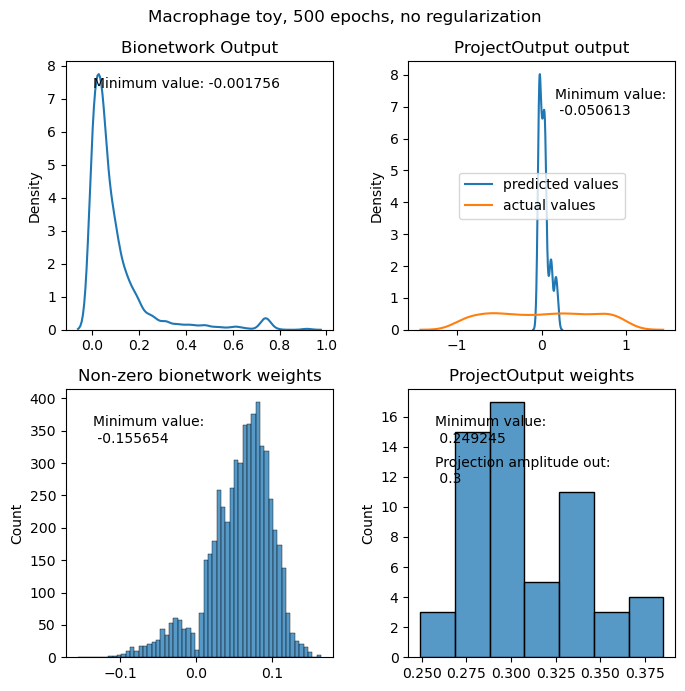

In [49]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (7,7))

vals = Y_full.detach().cpu().numpy().flatten()
sns.kdeplot(vals, ax = ax[0,0])
ax[0,0].annotate('Minimum value: {:4f}'.format(np.min(vals)), xy = (0.1, 0.9), xycoords = 'axes fraction')
ax[0,0].set_title('Bionetwork Output')

vals = Y_hat.detach().cpu().numpy().flatten()
sns.kdeplot(vals, ax = ax[0,1], label = 'predicted values')
ax[0,1].annotate('Minimum value: \n {:4f}'.format(np.min(vals)), xy = (0.55, 0.8), xycoords = 'axes fraction')
vals = y_train.detach().cpu().numpy().flatten()
sns.kdeplot(vals, ax = ax[0,1], label = 'actual values')
ax[0,1].set_title('ProjectOutput output')
ax[0, 1].legend(loc = 'center')

vals = mod.signaling_network.weights.cpu().detach().numpy()
sns.histplot(vals[vals!=0], ax = ax[1,0])
ax[1,0].annotate('Minimum value: \n {:4f}'.format(np.min(vals)), xy = (0.1, 0.8), xycoords = 'axes fraction')
ax[1,0].set_title('Non-zero bionetwork weights')

vals = mod.output_layer.weights.cpu().detach().numpy()
sns.histplot(vals, ax = ax[1,1])
ax[1,1].annotate('Minimum value: \n {:4f}'.format(np.min(vals)), xy = (0.1, 0.8), xycoords = 'axes fraction')
ax[1,1].annotate('Projection amplitude out: \n {:.1f}'.format(mod.projection_amplitude_out), xy = (0.1, 0.65), xycoords = 'axes fraction')
ax[1,1].set_title('ProjectOutput weights')

title_str = 'Macrophage toy, 500 epochs, no regularization'
# title_str += ', \n ProjectOutput has a bias term'
fig.suptitle(title_str)

fig.tight_layout()

# End dev

### Train Model

In [11]:
# model setup
mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

# loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam

# training loop
res = train_signaling_model(mod, optimizer, loss_fn,
                            reset_epoch = 200,
                            hyper_params = hyper_params,
                            train_split_frac = {'train': 0.8, 'test': 0.2, 'validation': None},
                            train_seed = seed,
                            verbose = True)
mod, cur_loss, cur_eig, mean_loss, stats, X_train, X_test, X_val, y_train, y_test, y_val = res

# store results
io.write_pickled_object(stats, os.path.join(data_path, 'training_stats.pickle'))
torch.save(obj=mod.state_dict(), f=os.path.join(data_path, 'mac_state_dict.pth'))

i=0, l=0.27186, s=0.775, r=0.00020, v=0
i=250, l=0.04416, s=0.571, r=0.00046, v=1
i=500, l=0.02875, s=0.777, r=0.00110, v=0
i=750, l=0.02331, s=0.768, r=0.00174, v=0
i=1000, l=0.01541, s=0.788, r=0.00200, v=0
i=1250, l=0.01102, s=0.754, r=0.00198, v=0
i=1500, l=0.00911, s=0.751, r=0.00191, v=0
i=1750, l=0.00905, s=0.763, r=0.00181, v=2
i=2000, l=0.00640, s=0.797, r=0.00167, v=1
i=2250, l=0.00821, s=0.820, r=0.00150, v=0
i=2500, l=0.00622, s=0.828, r=0.00131, v=0
i=2750, l=0.00506, s=0.809, r=0.00110, v=0
i=3000, l=0.00477, s=0.831, r=0.00090, v=0
i=3250, l=0.00417, s=0.844, r=0.00069, v=1
i=3500, l=0.00372, s=0.853, r=0.00050, v=0
i=3750, l=0.00357, s=0.849, r=0.00033, v=1
i=4000, l=0.00410, s=0.857, r=0.00019, v=1
i=4250, l=0.00398, s=0.872, r=0.00009, v=0
i=4500, l=0.00323, s=0.874, r=0.00002, v=0
i=4750, l=0.00369, s=0.873, r=0.00000, v=0
Training ran in: 28 min 17.74 sec


## Predict using the model:

In [12]:
mod.load_state_dict(torch.load(os.path.join(data_path, 'mac_state_dict.pth')))
stats = io.read_pickled_object(os.path.join(data_path, 'training_stats.pickle'))

In [13]:
mod.eval()
Y_hat, Y_full = mod(X_test)

## Visualize

Let's see how the various stats performed across training:

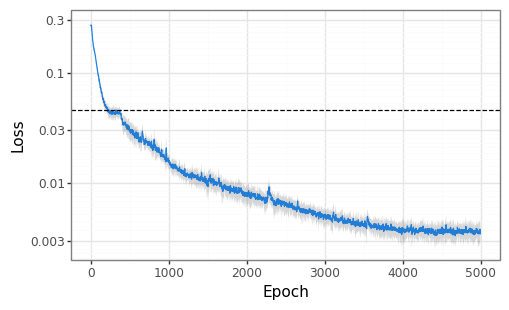

In [14]:
loss_smooth = utils.get_moving_average(values = stats['loss_mean'], n_steps = 5)
loss_sigma_smooth = utils.get_moving_average(values = stats['loss_sigma'], n_steps = 10)
epochs = np.array(range(stats['loss_mean'].shape[0]))

p1A = plotting.shade_plot(X = epochs, Y = loss_smooth, sigma = loss_sigma_smooth, x_label = 'Epoch', y_label = 'Loss')
p1A += p9.scale_y_log10()
p1A += p9.geom_hline(yintercept = mean_loss.item(), linetype="dashed", color="black")
p1A.draw()

As well as how the learning rate was adjusted across training:

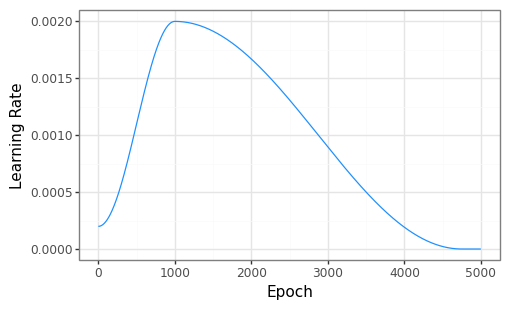

In [15]:
viz_df = pd.DataFrame(data = {'Epoch': epochs, 'lr': stats['learning_rate']})
width, height = 5, 3
p1B = (
    p9.ggplot(viz_df, p9.aes(x='Epoch', y = 'lr')) +
    p9.geom_line(color = '#1E90FF') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.ylab('Learning Rate')
)
p1B.draw()

As well as the spectral radius:

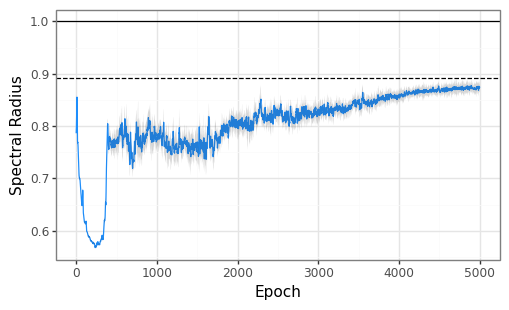

In [16]:
eig_smooth = utils.get_moving_average(stats['eig_mean'], 5)
eig_sigma_smooth = utils.get_moving_average(stats['eig_sigma'], 5)

p1C = plotting.shade_plot(X = epochs, Y = eig_smooth, sigma = eig_sigma_smooth, x_label = 'Epoch', y_label = 'Spectral Radius')
p1C += p9.geom_hline(yintercept = mod.signaling_network.training_params['spectral_target'], linetype="dashed", color="black")
p1C += p9.geom_hline(yintercept = 1, color="black")
p1C.draw()

Next, let's see what the correlation between the predicted and actual transcription factor is:

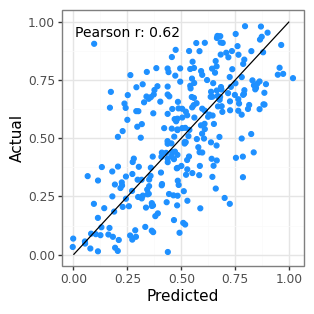

In [17]:
y_pred = Y_hat.detach().flatten().cpu().numpy()
y_actual = y_test.detach().flatten().cpu().numpy()

pr, _ = pearsonr(y_pred, y_actual)

viz_df = pd.DataFrame(data = {'Predicted': y_pred, 'Actual': y_actual})
width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF') +
    p9.geom_line(data = pd.DataFrame(data = {'x': [0,1], 'y': [0, 1]}), mapping = p9.aes(x='x', y = 'y'), color = 'black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(geom = 'text', x=0.25, y = 0.95, label = 'Pearson r: {:.2f}'.format(pr), size = 10)
)
p2.draw()

Finally, let's see how our prediction error compares to error of the prediction relative to a control predicted on an input of no ligands. 

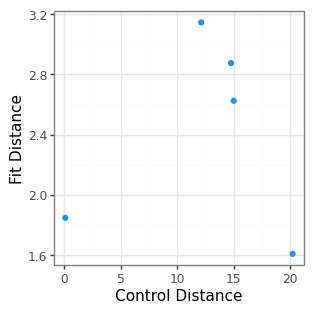

In [18]:
X_ctrl = torch.zeros((1, X_test.shape[1]), dtype=mod.dtype, device = mod.device)
Y_ctrl, _ = mod(X_ctrl)
signal_distance = torch.sum(torch.abs(Y_hat - Y_ctrl),dim=1).detach().cpu().numpy().flatten()
fit_distance = torch.sum(torch.square(Y_hat-y_test),dim=1).detach().cpu().numpy().flatten()


viz_df = pd.DataFrame(data = {'Control Distance': signal_distance, 'Fit Distance': fit_distance})
width, height = 3, 3
p3 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Control Distance', y = 'Fit Distance'), color = '#1E90FF') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) 
)
p3.draw()